In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
!unzip road_signs.zip

Archive:  road_signs.zip
  inflating: annotations/road0.xml   
  inflating: annotations/road1.xml   
  inflating: annotations/road10.xml  
  inflating: annotations/road100.xml  
  inflating: annotations/road101.xml  
  inflating: annotations/road102.xml  
  inflating: annotations/road103.xml  
  inflating: annotations/road104.xml  
  inflating: annotations/road105.xml  
  inflating: annotations/road106.xml  
  inflating: annotations/road107.xml  
  inflating: annotations/road108.xml  
  inflating: annotations/road109.xml  
  inflating: annotations/road11.xml  
  inflating: annotations/road110.xml  
  inflating: annotations/road111.xml  
  inflating: annotations/road112.xml  
  inflating: annotations/road113.xml  
  inflating: annotations/road114.xml  
  inflating: annotations/road115.xml  
  inflating: annotations/road116.xml  
  inflating: annotations/road117.xml  
  inflating: annotations/road118.xml  
  inflating: annotations/road119.xml  
  inflating: annotations/road12.xml  
  inf

Load Data

In [7]:
!mkdir road_signs
!mkdir road_signs/images_resized
!mkdir road_signs/road_signs_test
!mv images ./road_signs
!mv annotations ./road_signs

In [8]:
images_path = Path('./road_signs/images')
anno_path = Path('./road_signs/annotations')

In [9]:
def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [10]:
df_train = generate_train_df(anno_path)

In [11]:
#label encode target
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [12]:
print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,road_signs/images/road49.png,400,284,3,84,34,124,117
1,road_signs/images/road55.png,400,267,1,113,88,201,179
2,road_signs/images/road502.png,300,400,0,222,78,298,177
3,road_signs/images/road281.png,300,400,0,126,139,169,184
4,road_signs/images/road140.png,400,267,2,110,81,150,121


Resizing image and bounding boxes

In [13]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [14]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [15]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [16]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('./road_signs/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

Sample Images

In [19]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(400, 300, 3)


In [20]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([211., 177., 229., 194.], dtype=float32)

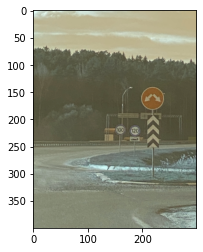

In [21]:
plt.imshow(im)

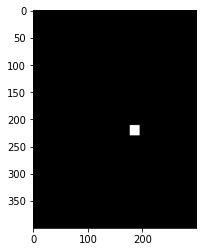

In [22]:
plt.imshow(Y, cmap='gray')

Data Augmentation

In [23]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [24]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [25]:
def create_corner_rect(bb, color='red'):
    print(bb)
    bb = np.array(bb, dtype=np.float32)
    print(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

Sample Image

[ 96. 138. 130. 202.]
[ 96. 138. 130. 202.]


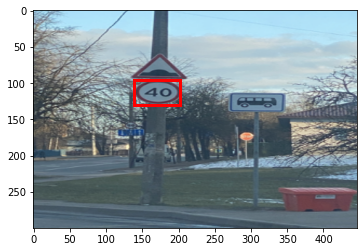

In [26]:
#original
im = cv2.imread(str(df_train.values[68][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[68][9])

[ 90. 237. 126. 302.]
[ 90. 237. 126. 302.]


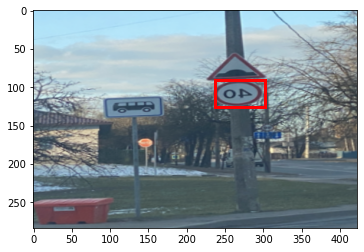

In [27]:
# after transformation
im, bb = transformsXY(str(df_train.values[68][8]),df_train.values[68][9],True )
show_corner_bb(im, bb)

Train-Valid Split

In [28]:
df_train = df_train.reset_index()

In [29]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Dataset

In [31]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [32]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [33]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [34]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

Model

In [35]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

Training

In [36]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [37]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [38]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [39]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [40]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

train_loss 2.447 val_loss 106594.227 val_acc 0.080
train_loss 1.761 val_loss 8045.931 val_acc 0.080
train_loss 1.461 val_loss 196.190 val_acc 0.085
train_loss 1.322 val_loss 1.766 val_acc 0.756
train_loss 1.207 val_loss 1.315 val_acc 0.761
train_loss 1.058 val_loss 0.913 val_acc 0.778
train_loss 0.970 val_loss 0.909 val_acc 0.790
train_loss 0.932 val_loss 0.883 val_acc 0.778
train_loss 0.912 val_loss 1.003 val_acc 0.761
train_loss 0.904 val_loss 1.049 val_acc 0.767
train_loss 0.849 val_loss 0.942 val_acc 0.761
train_loss 0.840 val_loss 1.023 val_acc 0.739
train_loss 0.830 val_loss 0.748 val_acc 0.812
train_loss 0.860 val_loss 0.774 val_acc 0.807
train_loss 0.838 val_loss 0.811 val_acc 0.795


0.8376880215850264

In [41]:
update_optimizer(optimizer, 0.001)
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

train_loss 0.884 val_loss 0.750 val_acc 0.824
train_loss 0.777 val_loss 0.745 val_acc 0.830
train_loss 0.775 val_loss 0.745 val_acc 0.841
train_loss 0.789 val_loss 0.736 val_acc 0.835
train_loss 0.731 val_loss 0.732 val_acc 0.824
train_loss 0.753 val_loss 0.734 val_acc 0.824
train_loss 0.735 val_loss 0.735 val_acc 0.830
train_loss 0.770 val_loss 0.727 val_acc 0.830
train_loss 0.717 val_loss 0.721 val_acc 0.835
train_loss 0.712 val_loss 0.715 val_acc 0.807


0.7119530583924472

Make Prediction

In [42]:
# choose random image from validation set
X_val

,new_path,new_bb
710,road_signs/images_resized/road779.png,"[106.0, 101.0, 201.0, 290.0]"
734,road_signs/images_resized/road381.png,"[117.0, 187.0, 146.0, 247.0]"
244,road_signs/images_resized/road9.png,"[89.0, 120.0, 251.0, 235.0]"
231,road_signs/images_resized/road339.png,"[34.0, 136.0, 122.0, 307.0]"
291,road_signs/images_resized/road144.png,"[23.0, 115.0, 258.0, 366.0]"
...,...,...
500,road_signs/images_resized/road722.png,"[155.0, 188.0, 184.0, 247.0]"
215,road_signs/images_resized/road861.png,"[75.0, 183.0, 110.0, 255.0]"
350,road_signs/images_resized/road172.png,"[126.0, 199.0, 139.0, 226.0]"
81,road_signs/images_resized/road832.png,"[31.0, 110.0, 120.0, 292.0]"


In [82]:
# resizing test image
im = read_image('./road_signs/images_resized/road722.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./road_signs/road_signs_test/road722.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [83]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./road_signs/road_signs_test/road722.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [84]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [85]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 2.1426, -1.9879, -0.3245, -1.9685]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[109.2840, 170.3756, 157.3811, 255.8972]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [86]:
# predicted class
torch.max(out_class, 1)
print(list(class_dict.keys())[list(class_dict.values()).index(torch.argmax(out_class))])

speedlimit


[109 170 157 255]
[109. 170. 157. 255.]


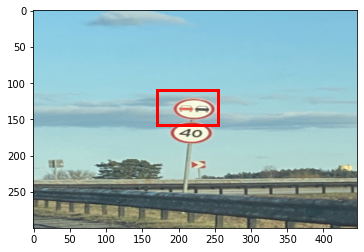

In [87]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [90]:
def create_corner_rect1(bb,img,label, color='red'):
    print(bb)
    bb = np.array(bb, dtype=np.float32)
    print(bb)
    print(label)
    _ = cv2.rectangle(img, (bb[1], bb[0]), (bb[3], bb[2]), (255,0,0), 2)
    cv2.putText(img, str(label), (int(bb[1]), int(bb[0])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    cv2.imwrite('./person_1.png',img)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb1(im,label, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect1(bb,im, label))

[109 170 157 255]
[109. 170. 157. 255.]
speedlimit


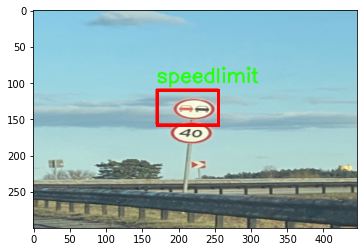

In [92]:
label = list(class_dict.keys())[list(class_dict.values()).index(torch.argmax(out_class))]
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb1(im, label,bb_hat[0])